In [94]:
from aaai_22 import AAAI_22_Dataset
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
import os
import sys
child_dir = os.path.abspath('dfl')
sys.path.append(child_dir)
from dfl.whittle import newWhittleIndex
from dfl.trajectory import getSimulatedTrajectories
from dfl.policy import getProbs
from dfl.ope import eval_policy
import matplotlib.pyplot as plt
import datetime
import random
import os
import sys
from dataset_utils import extract_mdps, extract_budget, split_offline_traj
child_dir = os.path.abspath('dfl')
sys.path.append(child_dir)

from data_loader import StudyDataLoader
warnings.filterwarnings("ignore")

In [95]:
dataset = AAAI_22_Dataset()
dl = StudyDataLoader('April21', '2021-07-07')
features = dl.feat_df[dl.experiment_df["exp_group"] == 'rmab']

2023-08-06 01:08:53,349 - INFO - load_data - Loading data from folder 'data/feb16-mar15_data'
2023-08-06 01:08:53,356 - INFO - load_call_data - Found 1 files in 'data/feb16-mar15_data/call'.
2023-08-06 01:08:53,357 - INFO - load_call_data - Loading and cleaning call data.
100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.43s/it]


Pandas Apply:   0%|          | 0/244 [00:00<?, ?it/s]

2023-08-06 01:09:11,467 - WARNING - gest_age_to_list - 1 is not a valid gestation age.
2023-08-06 01:09:11,467 - WARNING - gest_age_to_list - 2 is not a valid gestation age.
2023-08-06 01:09:11,467 - WARNING - gest_age_to_list - 3 is not a valid gestation age.
2023-08-06 01:09:11,468 - WARNING - gest_age_to_list - 4 is not a valid gestation age.
2023-08-06 01:09:11,468 - WARNING - gest_age_to_list - 5 is not a valid gestation age.
2023-08-06 01:09:11,468 - WARNING - gest_age_to_list - 6 is not a valid gestation age.
2023-08-06 01:09:11,468 - WARNING - gest_age_to_list - 7 is not a valid gestation age.
2023-08-06 01:09:11,469 - WARNING - gest_age_to_list - 38 is not a valid gestation age.
2023-08-06 01:09:11,469 - WARNING - gest_age_to_list - 39 is not a valid gestation age.
2023-08-06 01:09:11,469 - WARNING - gest_age_to_list - 2 is not a valid gestation age.
2023-08-06 01:09:11,470 - WARNING - gest_age_to_list - 3 is not a valid gestation age.
2023-08-06 01:09:11,470 - WARNING - gest_

2023-08-06 01:09:11,503 - WARNING - gest_age_to_list - 44 is not a valid gestation age.
2023-08-06 01:09:11,503 - WARNING - gest_age_to_list - 43 is not a valid gestation age.
2023-08-06 01:09:11,503 - WARNING - gest_age_to_list - 40 is not a valid gestation age.
2023-08-06 01:09:11,503 - WARNING - gest_age_to_list - 48 is not a valid gestation age.
2023-08-06 01:09:11,503 - WARNING - gest_age_to_list - 46 is not a valid gestation age.
2023-08-06 01:09:11,504 - WARNING - gest_age_to_list - 41 is not a valid gestation age.
2023-08-06 01:09:11,504 - WARNING - gest_age_to_list - 45 is not a valid gestation age.
2023-08-06 01:09:11,504 - WARNING - gest_age_to_list - 49 is not a valid gestation age.
2023-08-06 01:09:11,504 - WARNING - gest_age_to_list - 50 is not a valid gestation age.
2023-08-06 01:09:11,505 - WARNING - gest_age_to_list - 51 is not a valid gestation age.
2023-08-06 01:09:11,505 - WARNING - gest_age_to_list - 52 is not a valid gestation age.


Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

2023-08-06 01:09:12,518 - INFO - load_call_data - Call data contains 1250030 relevant call records for 23517 beneficiaries.
2023-08-06 01:09:12,529 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2023-08-06 01:09:12,529 - INFO - load_data - Beneficiary data contains data for 23517 beneficiaries
2023-08-06 01:09:12,534 - INFO - load_data - Call data contains 1250030 call records for 23517 beneficiaries
2023-08-06 01:09:13,912 - INFO - preprocess_and_make_dataset - Preprocessing beneficiary data.
2023-08-06 01:09:14,112 - INFO - preprocess_and_make_dataset - Preprocessing beneficiary data completed.
2023-08-06 01:09:14,112 - INFO - preprocess_and_make_dataset - Preprocessing call data.
2023-08-06 01:09:15,306 - INFO - preprocess_and_make_dataset - Preprocessing call data completed.
2023-08-06 01:09:15,307 - INFO - preprocess_and_make_dataset - Building the dataset.
2023-08-06 01:09:15,324 - INFO - preprocess_and_make_dataset - Preproccessed data has 23003 

In [96]:
def get_mdp_transitions(n_history, mdps):
    n = mdps.shape[0]
    transitions_full = np.zeros((n, 2 ** n_history, 2, 2 ** n_history))
    for i in range(n):
        for j in range(2 ** n_history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            trans = mdps[i,int(bin(j)[-1]), 0, :]
            transitions_full[i, j, 0, next_state_0] = trans[0]
            transitions_full[i, j, 0, next_state_1] = trans[1]

            # action = 1
            trans = mdps[i,int(bin(j)[-1]), 1, :]
            transitions_full[i, j, 1, next_state_0] = trans[0]
            transitions_full[i, j, 1, next_state_1] = trans[1]
    return transitions_full

In [97]:
def create_transitions_n_history(n_history,cluster_assignments,cluster_probabilities):
    n = len(cluster_assignments)
    transitions = np.zeros((n, 2, 2))
    for i in range(n_benefs):
        transitions[i, 0, 0] = cluster_probabilities[cluster_assignments[i]]['P(NE, I, E)']
        transitions[i, 0, 1] = cluster_probabilities[cluster_assignments[i]]['P(NE, A, E)']
        transitions[i, 1, 0] = cluster_probabilities[cluster_assignments[i]]['P(E, I, E)']
        transitions[i, 1, 1] = cluster_probabilities[cluster_assignments[i]]['P(E, A, E)']
    transitions_full = np.zeros((n, 2**n_history, 2, 2**n_history))
    for i in range(n):
        for j in range(2**n_history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            trans = transitions[i,int(bin(j)[-1]), 0]
            transitions_full[i, j, 0, next_state_0] = 1 - trans
            transitions_full[i, j, 0, next_state_1] = trans

            # action = 1
            trans = transitions[i,int(bin(j)[-1]), 1]
            transitions_full[i, j, 1, next_state_0] = 1 - trans
            transitions_full[i, j, 1, next_state_1] = trans

    return transitions_full

In [98]:
def get_simpleish_transitions(n_history,n_benefs):
    transitions_full = np.zeros((n_benefs, 2 ** n_history, 2, 2 ** n_history))
    transitions = np.zeros((2,2))
    for i in range(n_benefs):
        transitions[0, 0] = np.random.uniform(0, 0.3)
        transitions[0, 1] = np.random.uniform(.4, .7)
        transitions[1, 0] = np.random.uniform(0.3, .7)
        transitions[1, 1] = np.random.uniform(.701, .999)
        for j in range(2 ** history):
            bin_val = bin(j)[2:]
            curr_state = (n_history-len(bin_val))*'0' + bin_val
            next_state_0 = int(curr_state[1:] + '0', 2)
            next_state_1 = int(curr_state[1:] + '1', 2)

            # action = 0
            transitions_full[i, j, 0, next_state_0] = 1 - transitions[int(curr_state[-1]),0]
            transitions_full[i, j, 0, next_state_1] = transitions[int(curr_state[-1]),0]
            # action = 1
            transitions_full[i, j, 1, next_state_0] = 1 - transitions[int(curr_state[-1]),1]
            transitions_full[i, j, 1, next_state_1] = transitions[int(curr_state[-1]),1]
    return transitions_full

In [99]:
# Initialize parameters
import importlib
import dataset_utils
importlib.reload(dataset_utils)

L=11
history=3
n_states = 2 ** history
num_trials=1
n_policies=1

traj = dataset._get_offline_traj('rmab',L)
obj = pd.read_pickle(r'policy_dump.pkl')
cluster_probabilities = (obj[3]).iloc(0)
cluster_probs_assignments =  traj[2]

mdps,clusters = dataset_utils.extract_mdps(np.array(traj[1],dtype='int64')[None], 1,'clusters')
mdps = mdps[0]
benefs_includes = mdps[:,1,0,1]<0.78
transition_probabilities = mdps[mdps[:,1,0,1]<0.78]
transition_probabilities = get_mdp_transitions(history, transition_probabilities)
# transition_probabilities = get_simpleish_transitions(history,len(cluster_probs_assignments))
# cluster_transition_probabilities = create_transitions_n_history(history, cluster_probs_assignments, cluster_probabilities)

n = transition_probabilities.shape[0]
n_benefs=n

reward_numpy = np.zeros((n, n_states))
reward_numpy[:,1] = 1
reward_numpy[:,3] = 1
reward_numpy[:,5] = 1
reward_numpy[:,7] = 1
reward_opt = tf.constant(reward_numpy,dtype=tf.float32)

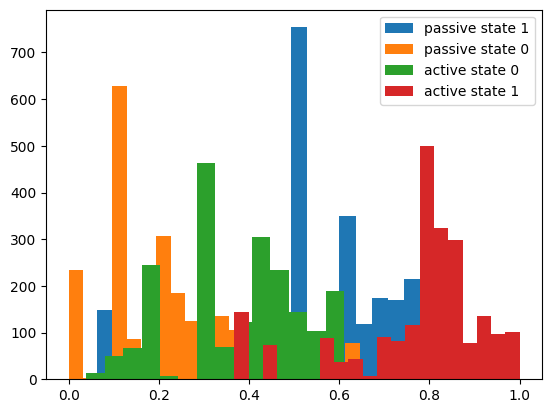

In [100]:
# Visualize Transition Probabilities

# Make sure everything adds to 1

# plt.hist(cluster_transition_probabilities[:,2,0,5]+cluster_transition_probabilities[:,2,0,4], bins=70, edgecolor='black')
# plt.hist(cluster_transition_probabilities[:,4,1,1]+cluster_transition_probabilities[:,4,1,0], bins=70, edgecolor='black')
# plt.hist(cluster_transition_probabilities[:,5,0,2]+cluster_transition_probabilities[:,5,0,3], bins=70, edgecolor='black')
# plt.hist(cluster_transition_probabilities[:,7,1,7]+cluster_transition_probabilities[:,7,1,6], bins=70, edgecolor='black')
plt.hist(mdps[:,1,0,1][benefs_includes], bins=20,label="passive state 1")
plt.hist(mdps[:,0,0,1][benefs_includes], bins=20, label="passive state 0")
plt.hist(mdps[:,0,1,1][benefs_includes], bins=20, label="active state 0")
plt.hist(mdps[:,1,1,1][benefs_includes], bins=20, label="active state 1")
# plt.hist(transition_probabilities[:,7,1,7]-transition_probabilities[:,7,0,7], bins=70,label=1)
# plt.hist(transition_probabilities[:,7,1,7]-transition_probabilities[:,6,1,7], bins=70,label=2)
# plt.hist(transition_probabilities[:,4,1,1]-transition_probabilities[:,4,0,1], bins=70,label=3)
# plt.hist(transition_probabilities[:,5,0,3]-transition_probabilities[:,4,0,1], bins=70,label=4)
plt.legend()


In [101]:
# optimal whittle indices if needed

w_opt = newWhittleIndex(tf.constant(transition_probabilities, dtype=tf.float32),reward_opt).numpy()
w_opt = np.reshape(w_opt,(n,transition_probabilities.shape[1]))

In [102]:
# Fix the state/action trajectories
traj = dataset._get_offline_traj('rmab',L)
joint_traj = traj[1]
state_traj = np.zeros((num_trials,n_policies,L,n))
action_traj = np.zeros((num_trials,n_policies,L,n))
actions_summary = {}
actions_count = {}
listening_count = {}
K = 0
i=0
for arm, value in enumerate(benefs_includes): # for each beneficary
    if value:
        for j in range(L): # for each timestep
            if j == 0:
                state_traj[0,0,j,i] = int('00' + str(int(joint_traj[arm][j][0])), 2) 
            elif j == 1: 
                state_traj[0,0,j,i] = int('0' + str(int(joint_traj[arm][j-1][0])) + str(int(joint_traj[arm][j][0])), 2) 
            else:
                state_traj[0,0,j,i] = int(str(int(joint_traj[arm][j-2][0])) + str(int(joint_traj[arm][j-1][0])) + str(int(joint_traj[arm][j][0])), 2) 
            action_traj[0,0,j,i] = joint_traj[arm][j][1]
            if action_traj[0,0,j,i] == 1:
                K += 1
        i+=1
K = int(K/L)
print(K)

76


In [103]:
# TESTING state transitions

for i in range(n): # for each beneficary
    for j in range(L): # for each timestep
        if j !=0:
            if state_traj[0,0,j-1,i] == 0:
                assert (state_traj[0,0,j,i] == 1 or state_traj[0,0,j,i] == 0)
            if state_traj[0,0,j-1,i] == 1:
                assert (state_traj[0,0,j,i] == 2 or state_traj[0,0,j,i] == 3)
            if state_traj[0,0,j-1,i] == 2:
                assert (state_traj[0,0,j,i] == 5 or state_traj[0,0,j,i] == 4)
            if state_traj[0,0,j-1,i] == 3:
                assert (state_traj[0,0,j,i] == 6 or state_traj[0,0,j,i] == 7)
            if state_traj[0,0,j-1,i] == 4:
                assert (state_traj[0,0,j,i] == 1 or state_traj[0,0,j,i] == 0)
            if state_traj[0,0,j-1,i] == 5:
                assert (state_traj[0,0,j,i] == 3 or state_traj[0,0,j,i] == 2)
            if state_traj[0,0,j-1,i] == 6:
                assert (state_traj[0,0,j,i] == 5 or state_traj[0,0,j,i] == 4)
            if state_traj[0,0,j-1,i] == 7:
                assert (state_traj[0,0,j,i] == 7 or state_traj[0,0,j,i] == 6)
            

2023-08-06 01:11:28,883 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 01:11:28,884 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


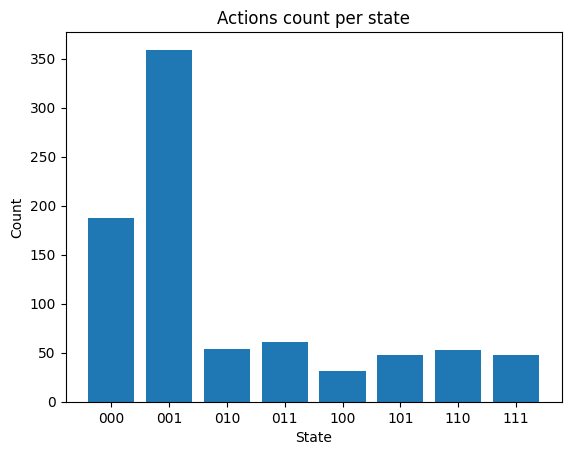

2023-08-06 01:11:28,966 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 01:11:28,967 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 01:11:28,970 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


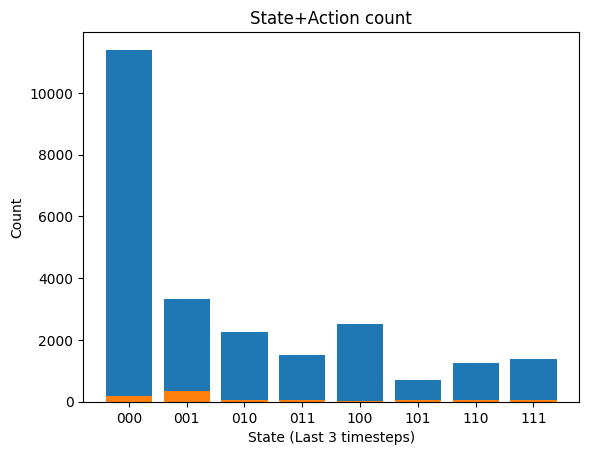

In [104]:
def plot_action_breakdown(states, actions,timestep=None):
    actions_by_state = np.zeros(n_states)
    state_counts = np.zeros(n_states)
    for i in range(n): # for each beneficary
        for j in range(L): # for each timestep
            if timestep == None:
                actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
                state_counts[int(states[0,0,j,i])] += 1
            else:
                if j ==timestep:
                    actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
                    state_counts[int(states[0,0,j,i])] += 1
    plt.xlabel('State')
    plt.ylabel('Count')
    plt.title('Actions count per state')

    plt.bar(['000','001','010','011','100','101','110','111'], actions_by_state)
    plt.show()

    plt.bar(['000','001','010','011','100','101','110','111'], state_counts)
    plt.bar(['000','001','010','011','100','101','110','111'], actions_by_state)
    plt.xlabel('State (Last 3 timesteps)')
    plt.ylabel('Count')
    plt.title('State+Action count')
    # Show the plot
    plt.show()

plot_action_breakdown(state_traj, action_traj)

2023-08-03 19:15:54,037 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-03 19:15:54,038 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


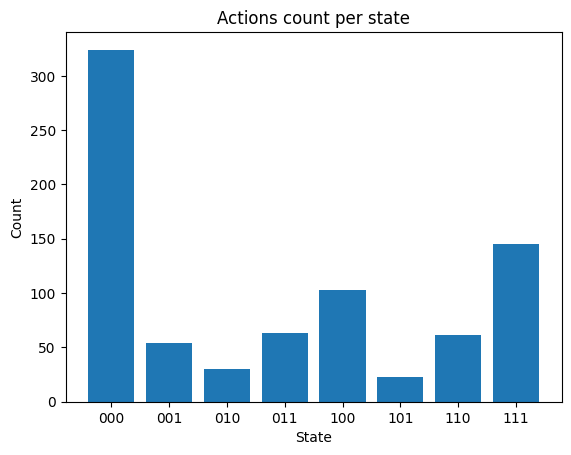

2023-08-03 19:15:54,109 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-03 19:15:54,110 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-03 19:15:54,113 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


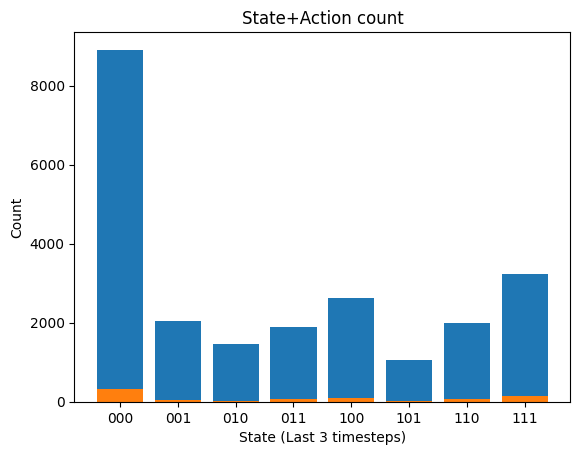

In [19]:
# See transition probability actions for synthetic data...
gamma=0.99
_, _, state_record_original, action_record_original, _ = getSimulatedTrajectories(
                                                                n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                w=w_opt, replace=False, policies=[3], fast=True
                                                                )

plot_action_breakdown(state_record_original, action_record_original)


2023-08-06 01:12:57,937 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 01:12:57,938 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


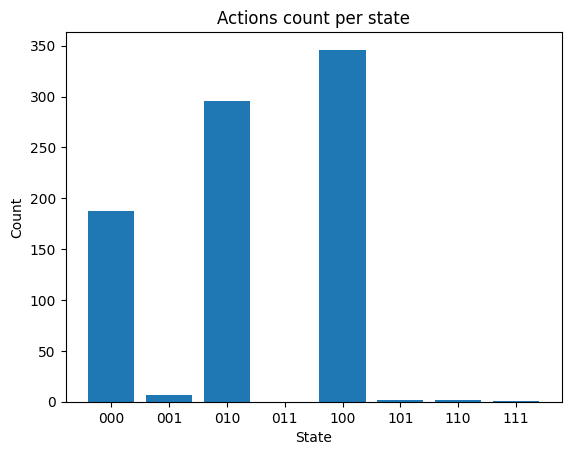

2023-08-06 01:12:58,015 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 01:12:58,016 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 01:12:58,019 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


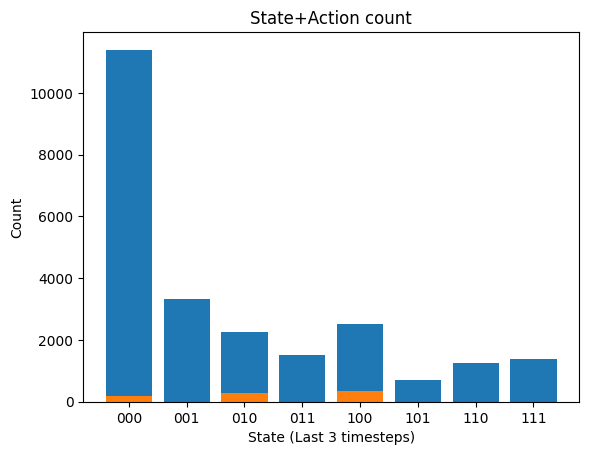

In [108]:
# editing trajectories based on content overlap

edited_action_traj_listenership = np.copy(action_traj)
edited_state_traj_listenership = np.copy(state_traj)

uncalled_low_listeners_by_timestep={}
called_high_listeners_by_timestep={}

def get_switched_listeners(states,actions,h):
    uncalled_low_listeners = set()
    called_high_listeners = set()
    for i in range(n): # for each beneficary
        if actions[0,0,h,i] == 1 and (states[0,0,h,i] in {7,6,5,3,1}):
            called_high_listeners.add(i)
        if actions[0,0,h,i] == 0 and (states[0,0,h,i] in {2,4}):
            uncalled_low_listeners.add(i)
    return(uncalled_low_listeners,called_high_listeners)

confidence = .999

for h in range(1,L):
    uncalled_low_listeners,called_high_listeners = get_switched_listeners(edited_state_traj_listenership,edited_action_traj_listenership,h)
    total = len(uncalled_low_listeners)
    interventions_available = len(called_high_listeners)
    probability_switching = min(float(interventions_available)/total,1)
#     print(probability_switching)
    for arm in range(n):
        if edited_action_traj_listenership[0,0,h,arm] == 0 and arm in uncalled_low_listeners and called_high_listeners != set():
            if np.random.random()<probability_switching:
                edited_action_traj_listenership[0,0,h,arm] = 1
                temp_index = called_high_listeners.pop()
                edited_action_traj_listenership[0,0,h,temp_index] = 0
#     print(len(called_high_listeners))
plot_action_breakdown(edited_state_traj_listenership, edited_action_traj_listenership)




In [109]:
def get_action_breakdown(states,actions,timestep=None):
    actions_by_state = np.zeros(n_states)
    for i in range(n): # for each beneficary
        for j in range(L): # for each timestep
            if timestep == None:
                actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
            else:
                if j ==timestep:
                    actions_by_state[int(states[0,0,j,i])] += actions[0,0,j,i]
    return actions_by_state

2023-08-14 07:49:11,365 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-14 07:49:11,366 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-14 07:49:11,380 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-14 07:49:11,382 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


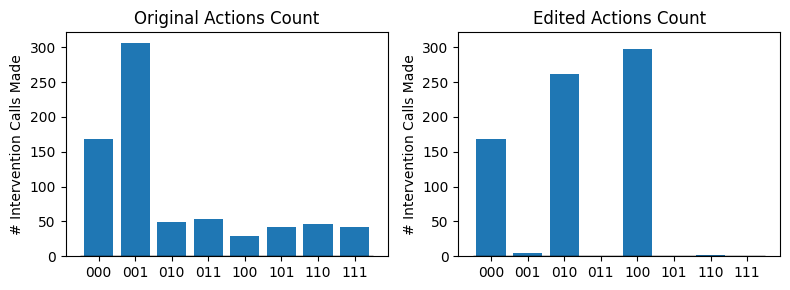

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3),sharey=True)
axs[0].set_title('Original Actions Count')
axs[0].set_ylabel('# Intervention Calls Made')
axs[0].bar(['000','001','010','011','100','101','110','111'], get_action_breakdown(state_traj, action_traj))
# for risk, val in zip(x, edited_actions_summary_risk_abs):
#     if val <0:
#         va='top'
#     else:
#         va='bottom'
#     axs[0].text(risk, int(val), str(int(val)), ha='center', va=va)
axs[1].bar(['000','001','010','011','100','101','110','111'], get_action_breakdown(edited_state_traj_listenership,edited_action_traj_listenership))
axs[1].set_title('Edited Actions Count')
axs[1].set_ylabel('# Intervention Calls Made')
# for risk, val in zip(x, edited_listening_summary_risk_abs):
#     if val <0:
#         va='top'
#     else:
#         va='bottom'
#     axs[1].text(risk, int(val), str(int(val)), ha='center', va=va)
axs[1].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)

# axs[1].set_yticks(np.linspace(axs[1].get_yticks()[0], axs[1].get_yticks()[-1], len(axs[1].get_yticks())))
axs[1].yaxis.set_tick_params(labelbottom=True)


plt.tight_layout()
plt.show()

In [111]:
# RUN IRL AGAIN WITH NEW TRAJECTORIES
# n=4

epochs = 30
gamma=0.99
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
uniform = True
if uniform:
    rewards = np.zeros((1,n_states))
    reward_param_edited = tf.Variable(rewards,dtype=float)
else:
    rewards = np.zeros((n, n_states))
    reward_param_edited = tf.Variable(rewards,dtype=float)
for epoch in range(epochs):
    print('EPOCH: {e}'.format(e=epoch))
    print('REWARD: {r}'.format(r=reward_param_edited))
    with tf.GradientTape() as tape:
        if uniform:
            reward_param_edited_n_benef = tf.repeat(reward_param_edited, n, axis=0)
            w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited_n_benef)
        else:
            w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), reward_param_edited)
        w = tf.reshape(w, (n, n_states))
        performance, _, _, _,_ = eval_policy(state_record=edited_state_traj_listenership, action_record=edited_action_traj_listenership, w=w, w_opt=w_opt, H=L, K=K,
                                                  gamma=gamma,
                                                 target_policy_name='soft-whittle', beh_policy_name='soft-whittle',
                                                 transition_probabilities=transition_probabilities, epsilon=0.1, reward_estimate=reward_param_edited_n_benef if uniform else reward_param_edited, rewards_true=reward_opt)
        print("PERFORMANCE: {p}".format(p=performance))
    grad = tape.gradient(performance, reward_param_edited)
    print('GRAD: {g}'.format(g=grad))
    optimizer.apply_gradients(zip([grad], [reward_param_edited]))

print(reward_param_edited)
df = pd.DataFrame(reward_param_edited.numpy())
df.to_excel('bug_fix_removed_benefs_edits_{m}_state_edited_{u}rewards_{time}.xlsx'.format(m=n_states,time=datetime.datetime.now(),u='uniform_' if uniform else ''))

EPOCH: 0
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>
PERFORMANCE: 2721.19580078125
GRAD: [[  881.16406  -260.69724  -605.37225  -573.30554  -227.75679  -915.07477
   -525.3958  -3147.2212 ]]
EPOCH: 1
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[-0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01]],
      dtype=float32)>
PERFORMANCE: 2732.417724609375
GRAD: [[ 493.0899   220.50209 -365.16507  269.36612  204.79668 -315.75363
   234.18903 2543.2527 ]]
EPOCH: 2
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[-0.01948182,  0.01030794,  0.01958175,  0.01289826,  0.01000448,
         0.01876208,  0.01308878,  0.01053209]], dtype=float32)>
PERFORMANCE: 2724.6279296875
GRAD: [[ 347.30533  235.48271 -331.03314  237.43523  217.76083 -321.51617
   207.14339 2685.0225 ]]
EPOCH: 3
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([

PERFORMANCE: 2596.584228515625
GRAD: [[ 289.4742    162.39279  -248.35207   381.24887   145.57262   -31.119677
   343.95453  2693.516   ]]
EPOCH: 24
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.01134771, -0.02467125,  0.13051102,  0.05541113, -0.02382467,
         0.19218312,  0.06469999, -0.01303117]], dtype=float32)>
PERFORMANCE: 2597.096435546875
GRAD: [[ 3.6446579e+02  1.9973267e+02 -1.7694954e+02  3.7859109e+02
   1.7772375e+02 -8.2704067e-01  3.3090424e+02  3.3836311e+03]]
EPOCH: 25
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.01216964, -0.02594073,  0.13593355,  0.05595544, -0.02509211,
         0.19828932,  0.06547625, -0.01381784]], dtype=float32)>
PERFORMANCE: 2593.91796875
GRAD: [[ 314.80396    171.3555    -167.62022    337.518      152.66246
    -6.5665016  293.67514   2945.756    ]]
EPOCH: 26
REWARD: <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=
array([[ 0.01226967, -0.02782922,  0.1414214

In [114]:
import os

current_path = os.getcwd()

# List all files in the current directory
files = os.listdir(current_path)
print(files)
df_original = pd.read_excel('bug_fix_removed_benefs_edits_8_state_edited_uniform_rewards_2023-08-06 01:50:07.955637.xlsx')
df_reward_param = df_original.values[:,1:]
print(df_reward_param)
print(np.shape(df_reward_param))
df_reward_param = np.repeat(df_reward_param, n, axis=0)
# print(np.shape(df_reward_param))
# w = newWhittleIndex(tf.constant(transition_probabilities,dtype=tf.float32), tf.Variable(df_reward_param, dtype=tf.float32))

['8_state_edited_uniform_rewards_2023-07-17 17:29:32.475178.xlsx', 'real_world_rewards_2023-07-06 14:49:21.159364.xlsx', 'bug_fix_transition_probabilities_8_state_real_world_data_removed_benefs_2023-08-06 01:50:08.005295.xlsx', '4_state_edited_uniform_rewards_2023-07-14 13:34:13.228995.xlsx', 'fast_listenership_metrics_computation.py', 'ArmmanIRL8state.ipynb', 'aaai_22_info.yml', 'nicetransitions_edits_epochs=30_edited_rewards_2023-07-30 12:17:34.590460.xlsx', '4_state_edited_rewards_2023-07-14 13:28:22.877465.xlsx', '8_state_edited_uniform_rewards_2023-07-18 14:25:40.503036.xlsx', 'Untitled1.ipynb', 'distribution_edits_8_state_edited_rewards_2023-07-28 18:32:40.951179.xlsx', 'real_world_rewards.xlsx', 'distribution_edits_8_state_edited_rewards_2023-07-27 15:38:25.647464.xlsx', '.DS_Store', 'edited_whittle_2023-07-13 13:50:04.463085.xlsx', 'CONFIG.py', 'edited_rewards_2023-07-11 14:54:55.791655.xlsx', 'Clean_Risk_Score_Experiments copy.ipynb', 'pilot_features.pkl', 'clean_epochs=50_edi

In [122]:
# Generate trajectories using the IRL rewards
gamma=0.99
num_traj = 40
L=10
edited_state_traj_multiple = np.zeros((num_traj,1,L+1,n))
edited_action_traj_multiple = np.zeros((num_traj,1,L+1,n))
w = np.reshape(w,(n,transition_probabilities.shape[1]))
# K=73
for i in range(num_traj):

    _, _, state_record_edited, action_record_edited, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=df_reward_param,
                                                                    w=w, replace=False, policies=[3], fast=True
                                                                    )
    
    edited_state_traj_multiple[i,0,:,:] = state_record_edited
    edited_action_traj_multiple[i,0,:,:] = action_record_edited
    

In [123]:
# Generate trajectories using the original rewards
gamma=0.99
state_traj_multiple = np.zeros((num_traj,1,L+1,n))
action_traj_multiple = np.zeros((num_traj,1,L+1,n))
for i in range(num_traj):
    _, _, state_record_original, action_record_original, _ = getSimulatedTrajectories(
                                                                    n_benefs=n, T=L+1, K=K, n_trials=1, gamma=gamma,
                                                                    T_data=transition_probabilities, R_data=reward_opt.numpy(),
                                                                    w=w_opt, replace=False, policies=[3], fast=True
                                                                    )
    state_traj_multiple[i,0,:,:] = state_record_original
    action_traj_multiple[i,0,:,:] = action_record_original


2023-08-06 12:19:24,953 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,954 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,959 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,963 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:24,968 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,072 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,086 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,087 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,087 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,088 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,148 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,148 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,149 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,150 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,150 - INFO - update - Using categorical units to plo

760.0
760.0


2023-08-06 12:19:25,157 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,158 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,159 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,159 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,159 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,195 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,196 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,196 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,197 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,200 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,242 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,243 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,243 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,244 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,244 - INFO - update - Using categorical units to plo

2023-08-06 12:19:25,325 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,325 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,326 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,327 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,337 - INFO - update - Using categorical units to plo

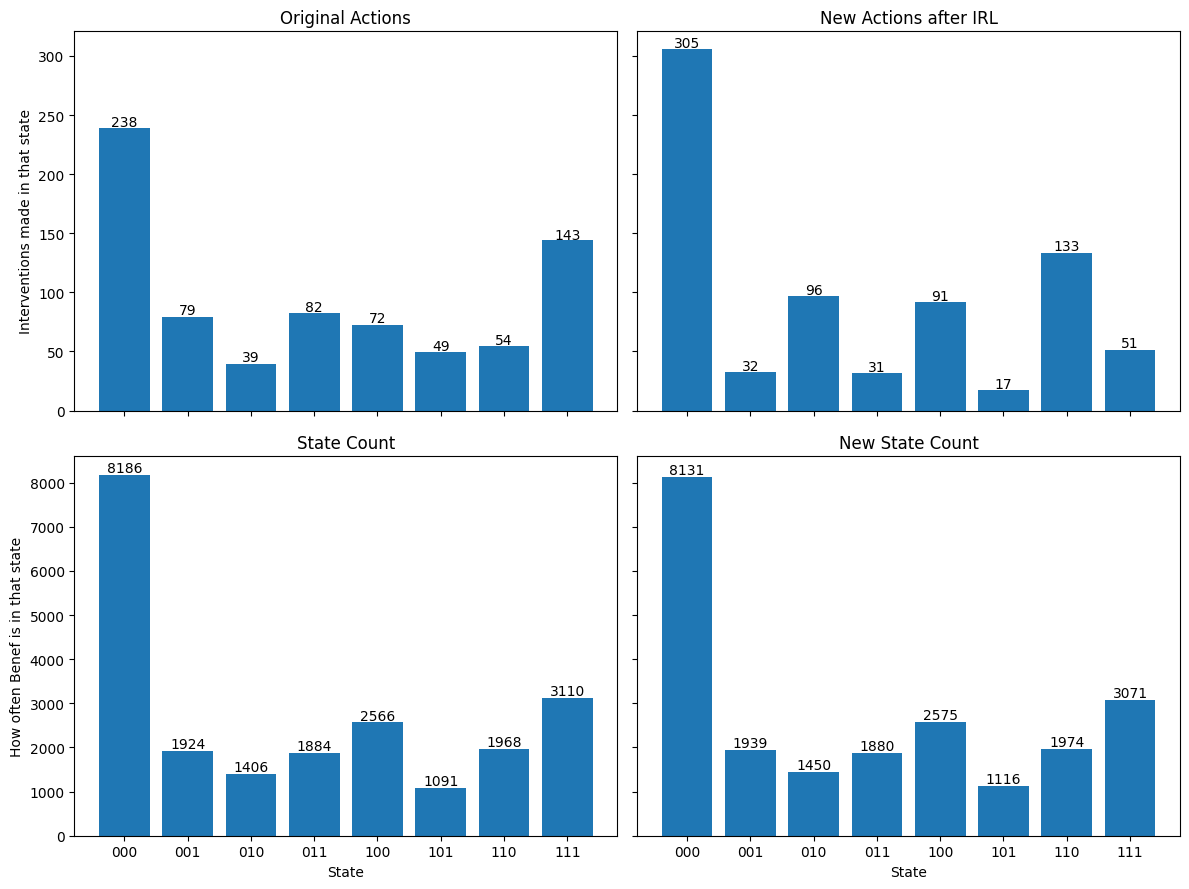

In [124]:
# Count original and edited interventions over states

edited_actions_summary_state = np.zeros(n_states)
edited_listening_summary_state = np.zeros(n_states)
actions_summary_state = np.zeros(n_states)
listening_summary_state = np.zeros(n_states)
for traj in range(num_traj):
    for i in range(n): # for each beneficary
        for h in range(L): # for each timestep
            # joint traj is of form (s,a,s',r)
            edited_actions_summary_state[int(edited_state_traj_multiple[traj,0,h,i])] += edited_action_traj_multiple[traj,0,h,i]
            edited_listening_summary_state[int(edited_state_traj_multiple[traj,0,h,i])] += 1
            actions_summary_state[int(state_traj_multiple[traj,0,h,i])] += action_traj_multiple[traj,0,h,i]
            listening_summary_state[int(state_traj_multiple[traj,0,h,i])] += 1
#                 actions_summary_state[int(state_traj[traj,0,h,i])] += action_traj[traj,0,h,i]
#                 listening_summary_state[int(state_traj[traj,0,h,i])] += 1
x = ['000','001','010','011','100','101','110','111']
edited_actions_summary_state = edited_actions_summary_state/num_traj
edited_listening_summary_state = edited_listening_summary_state/num_traj
actions_summary_state = actions_summary_state/num_traj
listening_summary_state = listening_summary_state/num_traj

print(np.sum(edited_actions_summary_state))
print(np.sum(actions_summary_state))

fig, axs = plt.subplots(2, 2, figsize=(12, 9),sharex=True, sharey='row')

# Plot the bar charts in each subplot
axs[0, 0].bar(x, actions_summary_state)
axs[0, 0].set_title('Original Actions')
axs[0, 0].set_ylabel('Interventions made in that state')
for state, val in zip(x, actions_summary_state):
    axs[0, 0].text(state, int(val), str(int(val)), ha='center', va='bottom')

axs[0, 1].bar(x, edited_actions_summary_state)
axs[0, 1].set_title('New Actions after IRL')
for state, val in zip(x, edited_actions_summary_state):
    axs[0, 1].text(state, int(val), str(int(val)), ha='center', va='bottom')

axs[1, 0].bar(x, listening_summary_state)
axs[1, 0].set_title('State Count')
axs[1, 0].set_ylabel('How often Benef is in that state')
axs[1, 0].set_xlabel('State')
for state, val in zip(x, listening_summary_state):
    axs[1, 0].text(state, int(val), str(int(val)), ha='center', va='bottom')
axs[1, 1].set_xlabel('State')


axs[1, 1].bar(x, edited_listening_summary_state)
axs[1, 1].set_title('New State Count')
for state, val in zip(x, edited_listening_summary_state):
    axs[1, 1].text(state, int(val), str(int(val)), ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

2023-08-06 12:19:25,425 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,426 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,430 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,431 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


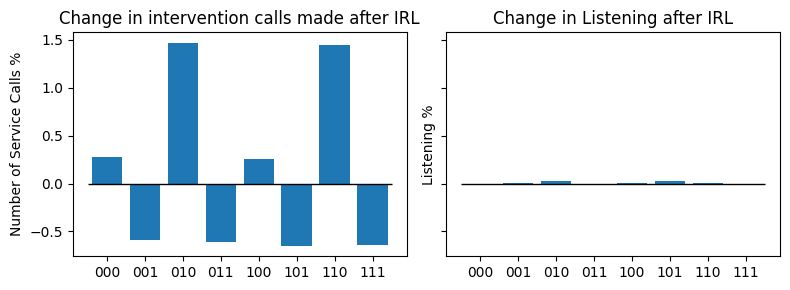

In [125]:
# Plot percentages

edited_actions_summary_risk_percent = (edited_actions_summary_state - actions_summary_state)/np.array(actions_summary_state,dtype=float)
edited_listening_summary_risk_percent = (edited_listening_summary_state - listening_summary_state)/np.array(listening_summary_state,dtype=float)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey='row')
axs[0].set_title('Change in intervention calls made after IRL')
axs[0].set_ylabel('Number of Service Calls %')
axs[0].bar(x, edited_actions_summary_risk_percent)

axs[1].bar(x, edited_listening_summary_risk_percent)
axs[1].set_title('Change in Listening after IRL')
axs[1].set_ylabel('Listening %')

axs[1].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)

plt.tight_layout()
plt.show()

2023-08-06 12:19:25,564 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,565 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,569 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-08-06 12:19:25,569 - INFO - update - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


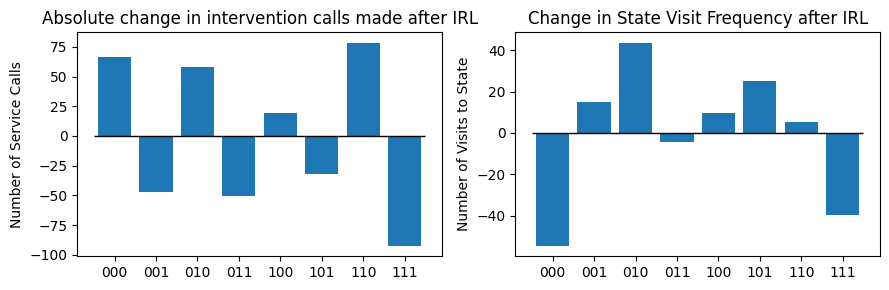

In [126]:
# Plot absolute change

edited_actions_summary_risk_abs = (edited_actions_summary_state - actions_summary_state)
edited_listening_summary_risk_abs = (edited_listening_summary_state - listening_summary_state)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].set_title('Absolute change in intervention calls made after IRL')
axs[0].set_ylabel('Number of Service Calls')
axs[0].bar(x, edited_actions_summary_risk_abs)

axs[1].bar(x, edited_listening_summary_risk_abs)
axs[1].set_title('Change in State Visit Frequency after IRL')
axs[1].set_ylabel('Number of Visits to State')

axs[1].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)
axs[0].hlines(0, -0.5, len(x) - 0.5, colors='black', linewidth=1)

plt.tight_layout()
plt.show()

In [112]:
flattened_data = transition_probabilities.reshape(transition_probabilities.shape[0], -1)

# Create a Pandas DataFrame for each "slice" along the first axis (axis 0)
tdfs = [pd.DataFrame(flattened_data[i].reshape(1, -1)) for i in range(transition_probabilities.shape[0])]

# Create an Excel writer
excel_writer = pd.ExcelWriter('bug_fix_transition_probabilities_8_state_real_world_data_removed_benefs_{t}.xlsx'.format(t=datetime.datetime.now()), engine='xlsxwriter')

# Write each DataFrame to a separate sheet in the Excel file
for i, tdf in enumerate(tdfs):
    tdf.to_excel(excel_writer, sheet_name=f'Sheet_{i}', index=False, header=False)

# Save the Excel file
excel_writer.close()

In [59]:
# Load the Excel file
excel_file = pd.ExcelFile('transition_probabilities_8_state_real_world_data_removed_benefs.xlsx')

# Get the sheet names
sheet_names = excel_file.sheet_names

# Initialize a list to store flattened arrays
flattened_arrays = []

# Iterate through each sheet and read data into DataFrames
for sheet_name in sheet_names:
    tdf = pd.read_excel(excel_file, sheet_name, header=None)
    flattened_arrays.append(tdf.values.flatten())

# Combine the flattened arrays to reconstruct the original 2D array
flattened_data = np.vstack(flattened_arrays)

# Reshape the flattened data to the original 4D shape (n, 8, 2, 8)
recovered_transitions = (flattened_data.shape[0], 8, 2, 8)
recovered_transitions = flattened_data.reshape(recovered_transitions)

# Close the Excel file
excel_file.close()

# Display the shape of the original array
print("Original array shape:", recovered_transitions.shape)


Original array shape: (2111, 8, 2, 8)


In [61]:
print(transition_probabilities[0,:,0,:])
print(recovered_transitions[0,:,0,:])

[[9.99990905e-01 9.09473783e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.32997195e-01 6.70028054e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.99990905e-01 9.09473783e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.32997195e-01 6.70028054e-02]
 [9.99990905e-01 9.09473783e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.32997195e-01 6.70028054e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.99990905e-01 9.09473783e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.32997195e-01 6.70028054e-02]]

In [91]:
# Plot new rewards

filtered_df_high = df_original[np.logical_or(risk_scores==2,risk_scores == 3,risk_scores == 1)]
filtered_df_low = df_original[risk_scores==0]

# plt.scatter(df_original[0],df_original[1],c=clusters, cmap='rainbow', s=5)
plt.scatter((filtered_df_high[0]), (filtered_df_high[1]),label="low risk",s=10)
plt.scatter((filtered_df_low[0]), (filtered_df_low[1]),label="high risk",s=10)

plt.title('Scatter Plot')
plt.legend()  # Show the legend

# Show the plot
plt.show()


NameError: name 'risk_scores' is not defined

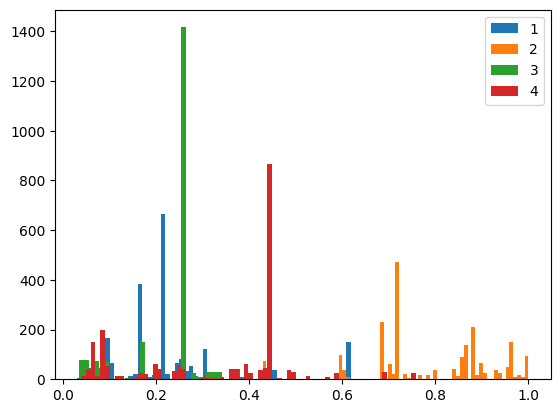

In [53]:
plt.hist(transition_probabilities[:,7,1,7]-transition_probabilities[:,7,0,7], bins=70,label=1)
plt.hist(transition_probabilities[:,7,1,7]-transition_probabilities[:,6,1,7], bins=70,label=2)
plt.hist(transition_probabilities[:,4,1,1]-transition_probabilities[:,4,0,1], bins=70,label=3)
plt.hist(transition_probabilities[:,5,0,3]-transition_probabilities[:,4,0,1], bins=70,label=4)
plt.legend()